Studie data voor Coverserver Porrima

In [ ]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

(500, 327)


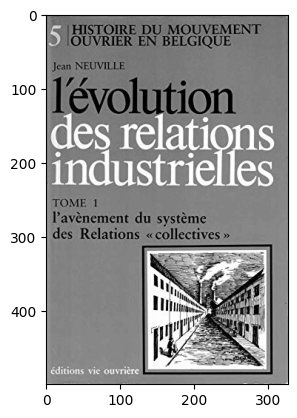

In [ ]:
DATADIR = r"/content/drive/MyDrive/covers"  # Path naar data op google drive
CATEGORIES = ["goede_covers", "slechte_covers"]  # Labels / Subfolders

for category in CATEGORIES:
    path = os.path.join(DATADIR, category)  # pad subfolder

    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)

        # inlezen in grayscale, kan nog aangepast worden naargelang performance
        # we gieten de images in een array

        plt.imshow(img_array, cmap="gray")
        print(img_array.shape)
        plt.show()
        break
    break

(300, 200)


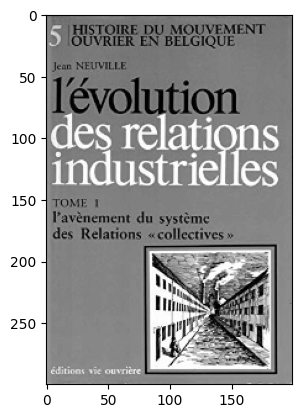

In [ ]:
IMG_SIZE = (200,300)
# gemiddelde aspect ratio cover = 1.5:1

new_array = cv2.resize(img_array, (IMG_SIZE[0], IMG_SIZE[1]))

print(new_array.shape)

plt.imshow(new_array, cmap='gray')
plt.show()

In [ ]:
training_data = []

def create_training_data():
  for category in CATEGORIES:
    path = os.path.join(DATADIR, category)  # pad subfolder
    class_num = CATEGORIES.index(category)
    # index van categories 0 wordt goed en 1 wordt slecht

    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        # inlezen in grayscale, kan nog aangepast worden naargelang performance
        # we gieten de images in een array
        new_array = cv2.resize(img_array, (IMG_SIZE[0], IMG_SIZE[1]))
        # resize operation
        training_data.append([new_array, class_num])
      except Exception as e:
        pass  # we passen in geval van corrupted image,...


create_training_data()

In [ ]:
goed = 0
for training_array in training_data:
  training_label_goed = training_array[-1]
  if training_label_goed == 0:
    goed += 1

print(f"{goed} / {len(training_data)} van de covers zijn slecht.")
print(f"{round(goed / len(training_data), 5)}% van de covers is goed.")

# !gewichten toekennen of minder goede covers gebruiken is nodig!

6924 / 9904 van de covers zijn slecht.
0.69911% van de covers is goed.


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

training_labels = list()
for e in training_data:
  training_labels.append(e[-1])

training_labels = np.array(training_labels)

# berekenen gewichten per klasse
# https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html
# balanced = balances out the dataset
# classes = unieke classes uit mijn array
# y = de classes per sample in een array
class_weights = compute_class_weight('balanced', classes=np.unique(training_labels), y=training_labels)

# we maken van de array een dict met class als key en weight als value
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)
# later gebruiken we de gewichten in model.fit

{0: 0.7151935297515887, 1: 1.661744966442953}


In [ ]:
import random

random.shuffle(training_data)
# shufflen van de data om bias tijdens het leren te voorkomen
for sample in training_data[:10]:
  print(sample[1])

In [ ]:
X = []  # features
y = []  # labels

for features, label in training_data:
  X.append(features)
  y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 1)
#  -1 is een catchall voor hoeveel features we hebben
#  1 is omdat we grayscale werken, bij kleur hebben we 3 waarden

In [ ]:
#normalizeren featuredata 0-1
X = X / 255

In [ ]:
# structuur van de feature-array is 4 dimensioneel
# 1 buitenste dimensie staat voor een afbeelding
# 2 de 'row of pixels' van de afbeelding
# 3 de 'column of pixels' van de afbeelding
# 4 de grayscale value van de pixel genormaliseerd van 0 tot 1
print(X[0]) # eerste image, 3 dimensionele array
print(X[0][0][0][0]) # waarde van eerste image, eerste rij, eerste kolom

In [ ]:
import os
np.save(os.path.join(DATADIR, 'featureset'), X)
np.save(os.path.join(DATADIR, 'labels'), y)

Mnist Voorbeeld Sequentieel Model

In [ ]:
# mnist voorbeeld
mnist = tf.keras.datasets.mnist

# definieren & normaliseren van data 0-1
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = tf.keras.utils.normalize(x_train, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)

# sequentieel model is lineair, laag per laag (functional is de tegenhanger)
model = tf.keras.models.Sequential()

# input layer
model.add(tf.keras.layers.Flatten())
# fully connected layers
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
# output layer
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['Accuracy'],)

# trainen model, parameters zijn de data, epoch = n passes door het NN
model.fit(x_train, y_train, epochs=3)

In [ ]:
# berekenen loss en accuracy op basis van test data
val_loss, val_acc = model.evaluate(x_test, y_test)
print(val_loss)
print(val_acc)

In [ ]:
# opslaan model
model.save('num_reader.model')

In [ ]:
# loaden model
new_model = tf.keras.models.load_model('num_reader.model')

In [ ]:
# altijd een list als parameter
predictions = new_model.predict([x_test])
print(predictions)
# dit zijn onze kansverdelingen in een array
#

In [ ]:
# dit print de voorspelling van x_test op index 0
print(np.argmax(predictions[2]))

In [ ]:
# printing image and tensor
plt.imshow(x_test[2], cmap=plt.cm.binary)
print(x_test[2])